***Note***

---

If you want to directly fit the GEV distribution using the trained NN, you can skip the code for generating the training set and go to the '***Save and load the neural model***' chunk for estimation.

## ***Required packages***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy
import math
import statistics
from numpy import random
from scipy.stats import genextreme as gev

import tensorflow as tf
from tensorflow import reduce_mean, square
import tensorflow.keras as keras
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, Dropout
import time
import pickle

## ***Abline function***

In [2]:
## Abline function
def abline(slope, intercept):
    """
    Function to add a straight line to the existing plot
    Arguments:
    * slope
    * intercept
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = 'magenta')

## ***Generate the parameters: Shape, Scale, and Location***

In [3]:
## Defining the number of training and validation sample size
n= 340000

n_train= 300000
print("Training Size",n_train)

n_valid= 40000
print("Validation Size",n_valid)

Training Size 300000
Validation Size 40000


## ***Generating parameter configurations for training and validation of the NN along with different sample sizes***


In [4]:
## Creating a discrete sequence of sample size to train the neural network (NN)
N_set= np.rint(10**np.linspace(start= math.log(30,10), stop=math.log(1000,10), num=5)).astype(int)
print('Discrete set of sample size', N_set)

over_all_factor= np.rint((n)/len(N_set)).astype(int)
print(over_all_factor)

Discrete set of sample size [  30   72  173  416 1000]
68000


In [5]:
## - Generate sample for the given factor
## idea: generate parameters over the parameteric range of size "overall_factor"
## and replicate it over each sample size in the N set.

random.seed(111)
shape_vals= random.uniform(-1, 0.4, over_all_factor) # c= -xi
scale_vals= 10**random.uniform(np.log10(0.1), np.log10(40), over_all_factor) # sigma
loc_vals= random.uniform(1, 50, over_all_factor) # mu

In [6]:
## --  Creating the parametric matrix for training and validation of the NN --
loc_values= np.hstack((loc_vals, loc_vals, loc_vals, loc_vals, loc_vals))
scale_values= np.hstack((scale_vals, scale_vals, scale_vals, scale_vals, scale_vals))
shape_values= np.hstack((shape_vals, shape_vals, shape_vals, shape_vals, shape_vals))

N_values= np.repeat(N_set, over_all_factor)

***NOTE:***

---



Generating the parameter configuration for varying sample sizes:
1. Define a given set of sample sizes 'N_set'
2. Fix the total simulation size to 'n'
3. Compute the overall multiplication factor for each unique value in 'N_set'
4. Generate parameter combinations (over the given range) of size 'overall_factor'
5. Sequentially generate GEV samples for the given parameter combinations over elements of 'N_set.' If the overall factor is 3, generate GEV samples first for a sample size of 30, then for 72, and so on, consecutively
6. Lastly, shuffle the final observation set for randomness.

In [7]:
# Stacking the columns to get a parametric matrix
parametric_matrix= np.transpose(np.vstack((loc_values, scale_values, shape_values, N_values)))

# Shuffling the rows
random.seed(123)
random.shuffle(parametric_matrix) # randomly shuffling

In [ ]:
### **NOT REQUIRED**
## %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17
## np.savetxt("parametric_matrix_-0.1_0.4.csv", parametric_matrix, delimiter=",")

In [10]:
### **NOT REQUIRED**
# ## To call the saved parameter matrix saved:
# parametric_matrix = np.array(pd.read_csv('/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/parametric_matrix_-1_0.4.csv', header=None))

In [8]:
loc_vals= (parametric_matrix[:, 0])
scale_vals= (parametric_matrix[:, 1])
shape_vals= (parametric_matrix[:, 2])

print('Max shape value', np.max(shape_vals)) # maximum value of the shape parameter, here  'c'
print('Min shape value', np.min(shape_vals)) # minimum value of c

print('Dimension of the parametric matrix', np.shape(parametric_matrix))
## Note:
## Columns in the parametric matrix represent: Location (μ), Scale (σ), Shape (c), and N (different sample sizes allocated to the parameter configuration).

N_vals= (parametric_matrix[:, 3]).astype(int)

Max shape value 0.3999970789497518
Min shape value -0.9999426082987267
Dimension of the parametric matrix (340000, 4)


In [9]:
## machine epsilon value for floating-point numbers
mch_epsilon = np.finfo(float).eps
print(mch_epsilon)

2.220446049250313e-16


In [10]:
##  Assuming 'shape_vals' is a NumPy array, again we are working with 'c':
is_weibull = shape_vals > mch_epsilon ## xi < 0 , i.e., c > 0
print('# of weibull =', sum(is_weibull))

is_frechet = shape_vals < -mch_epsilon  ## xi > 0 , i.e., c < 0
print('# of frechet =', sum(is_frechet))

is_gumbel = ~(is_weibull | is_frechet) # not weibull and not frechet
print('# of gumbel =', sum(is_gumbel))

# of weibull = 96975
# of frechet = 243025
# of gumbel = 0


In [11]:
## -- Defining the set of percentiles  'P'  --
## selected quantiles/percentiles mainly focus on the tail of the distribution,  along with the usual Q1, Q2, and Q3
p_set = np.array([0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])
print(p_set.shape)

(11,)


***Percentile Set:***

---





\begin{equation}
P = \left\{{\mathbf{0.01^{th}}, \hspace{0.1cm}\mathbf{0.1^{th}},
\hspace{0.1cm}\mathbf{1^{th}},  \hspace{0.1cm}\mathbf{{10}^{th}},  \hspace{0.1cm} {25}^{th},
\hspace{0.1cm} {50}^{th},
\hspace{0.1cm} {75}^{th},
\hspace{0.1cm}\mathbf{{90}^{th}},
\hspace{0.1cm}\mathbf{{99}^{th}},
\hspace{0.1cm}\mathbf{{99.9}^{th}}, \hspace{0.1cm}\mathbf{{99.99}^{th}}}\right \},
\end{equation}

where we have boldfaced the extreme percentile values for emphasis.

## ***Function to compute the Percentile Matrix***

***Note:***

---



We standardize the GEV samples first by using:
$$z=\dfrac{y- {median({y})}}{\mathrm{IQR}},$$

where  $median({y})$is the sample median, $\mathrm{IQR}$ is the sample interquartile range, and  $z$ is the standardized GEV sample.

Once standardized, we extract the summary statistics to train and validate the network.

In [12]:
## -- Function to compute the percentile matrix for the standardized data --
## here VS stands for varying sample (VS) size
def VS_Z_quantiles(seed, shape_vec, loc_vec, scale_vec, N_set):
    """
    Function to return 'Percentile Matrix'
    here n = n_train + n_valid.

    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape_vec, loc_vec, scale_vec = simulated shape, location, scale parameter values
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!
    * p_vec = quantile set
    * n_train = training size
    * n_valid = validation size
    * N = GEV sample generated for each parameter combination
      -> is set to 1000 for now.
    """
    ## setting the seed for sample generation
    random.seed(seed)

    ## Drawing sample of size N from GEV(shape, loc, scale)
    ## sample size (= training + valid set)
    n = len(shape_vec)

    ## -- Initializing the matrices & vectors --
    percentile_Matrix = np.empty((n, len(p_set))) ## store the counts
    storeSample = np.empty((n, max(N_set))) ## store the standardized sample
    std_storeSample = np.empty((n, max(N_set))) ## store the standardized sample

    storeIQR = [] ## store sample IQR
    storeMedian = [] ## store sample median

    ## -- Extracting counts --
    for i in range(n):

        # idiot numbers; just to check the loop
        if i%5525 == 0:
            print(i)

        # sample generation
        X_sample = gev.rvs(c=shape_vec[i],
                           loc=loc_vec[i],
                           scale=scale_vec[i],
                           size=N_set[i])

        # computing sample mean and sample variance
        Median = np.median(X_sample)
        IQR = scipy.stats.iqr(X_sample)

        storeMedian.append(Median)
        storeIQR.append(IQR)

        # standardization of the data
        Z_sample = (X_sample-Median)/IQR

        # storing the standardized sample
        percentile_Matrix[i,:] = np.percentile(Z_sample, p_set*np.array(100))


        # store std sample
        if len(X_sample)==1000:
            # storing the sample
            storeSample[i, :] = X_sample # dimension n*1000
            std_storeSample[i, :] = Z_sample  # dimension n*1000
        else:
            # we are working with varying sample size
            # some elements in the matrix will have NaN values
            fill_space_NaN = np.empty((max(N_set)-len(X_sample)))
            fill_space_NaN[:] = np.NaN
            storeSample[i,:] = np.concatenate((X_sample, fill_space_NaN))
            std_storeSample[i, :] = np.concatenate((Z_sample, fill_space_NaN))  # dimension n*1000

    return storeSample, std_storeSample, percentile_Matrix, np.array(storeMedian), np.array(storeIQR)

## ***Percentile for selected set of quantiles***

In [ ]:
# # -- Computing the Percentile Matrix for the different choices of parametric matrix  --
# # Working with sample size N_set
# # record time
start_time = time.time()
storeSample, std_storeSample, percentileMat, sampleMedians, sampleIQRs = VS_Z_quantiles(seed=122,
                                                                                        shape_vec=shape_vals,
                                                                                        loc_vec=loc_vals,
                                                                                        scale_vec=scale_vals,
                                                                                        N_set=N_vals)
tot_time_sample_sim = (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
5525
11050
16575
22100
27625
33150
38675
44200
49725
55250
60775
66300
71825
77350
82875
88400
93925
99450
104975
110500


In [ ]:
print('Total time taken to simulate the sample in mins', tot_time_sample_sim/3600, 'hrs')

In [ ]:
### ***NOT REQUIRED***
### -- To save the storeSample matrix in google drive --:
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17
# np.savetxt("storeSampl_-1_0.4.csv", storeSample, delimiter=",")

In [ ]:
### ***NOT REQUIRED***
# storeSample = np.array(pd.read_csv('/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/storeSampl_-1_0.4.csv', header=None))

In [ ]:
### ***NOT REQUIRED***
## -- Function to extract the percentile matrix for the loaded storeSample matrix --
# n = len(shape_vals)

# ## -- initializing the matrices & vectors --
# percentile_Matrix = np.empty((n,len(p_set)))# store the percentile matrix

# stdstoreSample = np.empty((n, max(N_set))) # store standardized sample
# ##storeSample= np.empty((n, max(N_set))) # store the sample

# storeIQR = [] # store sample IQR
# storeMedian = [] # store sample median

# ## -- Extracting Percentile from storeSample Matrix --
# for i in range(n):
#   ## idiot numbers; just to check the loop
#   if i%5525 == 0:
#     print(i)

#   ## sample generation
#   X_sample = storeSample[i,:]

#   ## computing sample median and sample variance

#   Median = np.nanmedian(X_sample)

#   percentile25, percentile75 = np.nanpercentile(X_sample, q=[25, 75])
#   IQR = percentile75 - percentile25

#   storeMedian.append(Median)
#   storeIQR.append(IQR)

#   ## standardization of the data
#   Z_sample = (X_sample-Median)/IQR

#   ## storing the standardized sample
#   percentile_Matrix[i,:] = np.nanpercentile(Z_sample,
#                                             p_set*np.array(100))

#   ## store std sample
#   if len(X_sample)==1000:
#     ## storing the sample
#     stdstoreSample[i, :]= Z_sample # dimension n*1000
#   else:
#     ## we are working with varying sample size
#     ## some elements in the matrix will have NaN values
#     fill_space_NaN= np.empty((max(N_set)-len(X_sample)))
#     fill_space_NaN[:]= np.NaN
#     stdstoreSample[i,:]= np.concatenate((Z_sample, fill_space_NaN))

# sampleMedians = np.array(storeMedian)
# sampleIQRs = np.array(storeIQR)
# std_storeSample = stdstoreSample

# percentileMat =  percentile_Matrix

### ***Scaling - mu (location) and  sigma (scale) parameter values***

In [ ]:
# With fixed seed, sample mean and variances are sample for all 3 different qunatile set
sc_loc_vals= (loc_vals/sampleIQRs) - (sampleMedians/sampleIQRs)
sc_scale_vals= scale_vals/sampleIQRs

In [ ]:
sc_loc_vals_df= pd.DataFrame(sc_loc_vals)
sc_loc_vals_df.describe()

,0
count,34000.000000
mean,-0.218292
std,0.097844
min,-1.070455
25%,-0.261177
50%,-0.211182
75%,-0.167088
max,0.480797


In [ ]:
sc_scale_vals_df= pd.DataFrame(sc_scale_vals)
sc_scale_vals_df.describe()

,0
count,34000.000000
mean,0.572984
std,0.154596
min,0.119624
25%,0.458584
50%,0.568414
75%,0.674357
max,2.775858


Comment: Sanity check for range of transformed scale/location value

In [ ]:
# Calculate mininum and maximum of the Orginal sample
print('Dimension of the storeSample matrix', storeSample.shape)

sample_min = np.nanmin(storeSample, axis=1)
print('Dimension of the sample_min  matrix', sample_min.shape)

sample_max = np.nanmax(storeSample, axis=1)
print('Dimension of the sample_max matrix', sample_max.shape)

# Calculate mininum and maximum of the standardized sample
print('Dimension of the std_storeSample matrix', std_storeSample.shape)

std_sample_min = np.nanmin(std_storeSample, axis=1)
print('Dimension of the std_sample_min  matrix', std_sample_min.shape)

std_sample_max = np.nanmax(std_storeSample, axis=1)
print('Dimension of the std_sample_max matrix', std_sample_max.shape)

Dimension of the storeSample matrix (34000, 1000)
Dimension of the sample_min  matrix (34000,)
Dimension of the sample_max matrix (34000,)
Dimension of the std_storeSample matrix (34000, 1000)
Dimension of the std_sample_min  matrix (34000,)
Dimension of the std_sample_max matrix (34000,)


### ***Checking the support constraint of the GEV distribution for the transformed parameters***

Note: Here tempI and tempII must be positive, to hold the GEV support constraint.

In [ ]:
tempI = shape_vals*(std_sample_min-sc_loc_vals)
tempII = shape_vals*(std_sample_max-sc_loc_vals)

In [ ]:
tempI = pd.DataFrame(tempI[is_frechet==True])
tempI.describe()

,0
count,24095.000000
mean,0.245885
std,0.106293
min,0.000251
25%,0.177872
50%,0.263534
75%,0.316826
max,1.275488


In [ ]:
tempII = pd.DataFrame(tempII[is_weibull==True])
tempII.describe()

,0
count,9905.000000
mean,0.426452
std,0.203297
min,0.000312
25%,0.267154
50%,0.454198
75%,0.590781
max,1.182495


In [ ]:
# Define delta parameter
# for frechet
# sc_sigma = c(z(1) - sc_mu) + exp(delta)
# delta = log(sc_sigma- c*(z(1)-sc_mu))
delta_frechet_vals = np.log(sc_scale_vals- shape_vals*(std_sample_min-sc_loc_vals))
print('Dimension of delta variable', delta_frechet_vals.shape)

# for weibull
# sc_sigma = c(z(n) - sc_mu) + exp(delta)
# delta = log(sc_sigma- c*(z(n)-sc_mu))
delta_weibull_vals = np.log(sc_scale_vals- shape_vals*(std_sample_max-sc_loc_vals))
print('Dimension of delta variable', delta_weibull_vals.shape)

Dimension of delta variable (34000,)
Dimension of delta variable (34000,)


### ***Reparameterization of $\sigma$ to $\delta$***

In [ ]:
# Define the common variable based on 'is_weibull'
delta_vals = np.where(is_weibull, delta_weibull_vals , delta_frechet_vals )

In [ ]:
delta_vals_df = pd.DataFrame(delta_vals)
delta_vals_df.describe()

,0
count,34000.000000
mean,-1.528103
std,0.724589
min,-6.315508
25%,-2.063717
50%,-1.463679
75%,-0.926587
max,0.719139


In [ ]:
## Median and IQR of the original sample
sampleMedians = np.reshape(sampleMedians, (-1,1))
print('Dim of sample Medians', np.shape(sampleMedians))

sampleIQRs = np.reshape(sampleIQRs, (-1,1))
print('Dim of sample IQRs', np.shape(sampleIQRs))

Dim of sample Medians (34000, 1)
Dim of sample IQRs (34000, 1)


In [ ]:
## Minimum and maximum for the orginal sample
sampleMin = np.reshape(sample_min, (-1,1))
print('Dim of std sample Minimum', sampleMin.shape)

sampleMax = np.reshape(sample_max, (-1,1))
print('Dimension of std sample Maximum', sampleMax.shape)

Dim of std sample Minimum (34000, 1)
Dimension of std sample Maximum (34000, 1)


In [ ]:
sampleMax_df = pd.DataFrame(sampleMax)
sampleMax_df.describe()

,0
count,3.400000e+04
mean,1.463050e+03
std,3.010153e+04
min,1.718610e+00
25%,3.484039e+01
50%,6.175544e+01
75%,1.950154e+02
max,2.875839e+06


In [ ]:
## Minimum and Maximum for the Standardized Sample
std_sampleMin = np.reshape(std_sample_min, (-1,1))
print('Dim of std sample Minimum', np.shape(std_sampleMin))

std_sampleMax = np.reshape(std_sample_max, (-1,1))
print('Dimension of std sample Maximum', std_sampleMax.shape)

Dim of std sample Minimum (34000, 1)
Dimension of std sample Maximum (34000, 1)


In [ ]:
std_sampleMax_df = pd.DataFrame(std_sampleMax)
std_sampleMax_df.describe()

,0
count,3.400000e+04
mean,1.220313e+02
std,5.722822e+03
min,5.551015e-01
25%,2.617669e+00
50%,6.263213e+00
75%,2.307852e+01
max,1.017232e+06


### ***Defining training and validation set***

In [ ]:
## -- Training set and Testing set --
Z_train = percentileMat[range(n_train), :] # Input to the NN
Z_valid = percentileMat[range(n_train,(n_train+n_valid)), :]

## Original sample
sample_train = storeSample[range(n_train), :]
sample_valid = storeSample[range(n_train,(n_train+n_valid)), :]

## Sample Minimum
sampleMin_train = sampleMin[range(n_train)]
sampleMin_valid = sampleMin[range(n_train,(n_train+n_valid))]

## Sample Maximum
sampleMax_train = sampleMax[range(n_train)]
sampleMax_valid = sampleMax[range(n_train,(n_train+n_valid))]

## Standardized sample
std_sample_train = std_storeSample[range(n_train), :]
std_sample_valid = std_storeSample[range(n_train,(n_train+n_valid)), :]

## Std Sample Minimum
std_sampleMin_train = std_sampleMin[range(n_train)]
std_sampleMin_valid = std_sampleMin[range(n_train,(n_train+n_valid))]

## Std Sample Maximum
std_sampleMax_train = std_sampleMax[range(n_train)]
std_sampleMax_valid = std_sampleMax[range(n_train,(n_train+n_valid))]

## Sample Median
sampleMedians_train = sampleMedians[range(n_train)]
sampleMedians_valid = sampleMedians[range(n_train,(n_train+n_valid))]


## Sample IQR
sampleIQRs_train = sampleIQRs[range(n_train)]
sampleIQRs_valid = sampleIQRs[range(n_train,(n_train+n_valid))]

## Response: Stacking the location, scale and shape parameters
Y = np.transpose((sc_loc_vals, delta_vals, shape_vals))
print("Dimension of Y vector/Parameter set",  Y.shape)

## Training, Validation and Testing Set
## Y: response varible here is the shape parameter
Y_train = Y[range(n_train), :]
print("Dimension of Y train",  Y_train.shape)

Y_valid = Y[range(n_train,(n_train+n_valid)), :]
print("Dimension of Y valid",  Y_valid.shape)

Dimension of Y vector/Parameter set (34000, 3)
Dimension of Y train (30000, 3)
Dimension of Y valid (4000, 3)


In [ ]:
#shape_vals_test= shape_vals[range((n_train+n_valid),n)]
#scale_vals_test= scale_vals[range((n_train+n_valid),n)]
#loc_vals_test= loc_vals[range((n_train+n_valid),n)]
#parameter_test= np.transpose((loc_vals_test, scale_vals_test, shape_vals_test))

#np.savetxt("parameter_test.csv", parameter_test, delimiter=",")
#np.savetxt("sample_test.csv", sample_test, delimiter=",")

# ***Model Build-Up***

### ***Input Size and Network Optimizer***


In [ ]:
## Input size for the network
input_shape= len(p_set)

## Optimizers with learning rate `1e-3'
optimizer= RMSprop(learning_rate = 1e-3)

### ***Defining network architecture***

In [ ]:
from sklearn.model_selection import train_test_split

## Clear session and set seed
tf.keras.backend.clear_session()
tf.random.set_seed(122)

## Initializer
initializer = tf.keras.initializers.GlorotUniform()

hidden_layers = [Dense(512, activation='relu', name='layer1', kernel_initializer=initializer),
                 Dense(512, activation='relu', name='layer2', kernel_initializer=initializer),
                 Dense(512, activation='relu', name='layer3', kernel_initializer=initializer),
                 Dense(128, activation='relu', name='layer4', kernel_initializer=initializer),
                 Dense(128, activation='relu', name='layer5', kernel_initializer=initializer),]


## Input layer
input_layer = Input(shape=input_shape, name='inputlayer')

## Pass through hidden layers
x = input_layer
for hidden_layer in hidden_layers:
    x = hidden_layer(x)

## Output layer with quantile loss
output_layer = Dense(units=3, activation='linear', name='outputlayer')(x)

## Create the model with Adam optimizer and quantile loss
model = Model(input_layer, output_layer)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
## extracting the initial weights
initial_weights= model.get_weights()

## -- using RMSprop optimizer --
model.compile(optimizer=optimizer, loss= 'mse', weighted_metrics=[]) # although our model uses the custom loss

In [ ]:
## -- Callbacks --
## paitence = # of epochs with no improvement after which training will be stopped
early_stopping= EarlyStopping(monitor='val_loss',
                              patience=8,
                              mode='min')
## paitence = # of epochs with no improvement after which learning rate will be reduced
reduce_lr_on_plateau= ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=3,
                                        mode='min')

In [ ]:
tf.config.run_functions_eagerly(True) # to pass numpy() in tensorflow evnr

## ***Training network***

In [ ]:
## resetting the model parameters back to their original
## record time
start_time = time.time()

model.set_weights(initial_weights)
n_epoch = 150

batch_size = 128 # change from 64 to 128

## training set
tensors_train = Z_train, Y_train
train_dataset = tf.data.Dataset.from_tensor_slices(tensors_train).batch(batch_size)

## validation set
tensors_valid = Z_valid, Y_valid
valid_dataset = tf.data.Dataset.from_tensor_slices(tensors_valid).batch(batch_size)


history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=n_epoch,
                    callbacks=[early_stopping, reduce_lr_on_plateau])

print("--- %s seconds ---" % (time.time() - start_time))
time_train = (time.time() - start_time)

Epoch 1/150
235/235 [==============================] - 24s 99ms/step - loss: 3159.2043 - val_loss: 25.7297 - lr: 0.0010
Epoch 2/150
235/235 [==============================] - 23s 98ms/step - loss: 3953.2166 - val_loss: 17.3674 - lr: 0.0010
Epoch 3/150
235/235 [==============================] - 23s 97ms/step - loss: 2189.3728 - val_loss: 3.9874 - lr: 0.0010
Epoch 4/150
235/235 [==============================] - 22s 93ms/step - loss: 153.5126 - val_loss: 0.6258 - lr: 0.0010
Epoch 5/150
235/235 [==============================] - 16s 66ms/step - loss: 467.9074 - val_loss: 7.4608 - lr: 0.0010
Epoch 6/150
235/235 [==============================] - 19s 80ms/step - loss: 75.1864 - val_loss: 5.8779 - lr: 0.0010
Epoch 7/150
235/235 [==============================] - 24s 101ms/step - loss: 82.3117 - val_loss: 34.0857 - lr: 0.0010
Epoch 8/150
235/235 [==============================] - 18s 75ms/step - loss: 15.9324 - val_loss: 0.3253 - lr: 1.0000e-04
Epoch 9/150
235/235 [===========================

In [ ]:
## Time to train the NN
print('Time to train the network on 300k observation size', time_train/3600,'hrs')

Time to train the network on 300k observation size 0.3062672339545356 hrs


In [ ]:
model.optimizer.lr.numpy()

1.0000001e-10

### ***Plots for checking the network behavior***

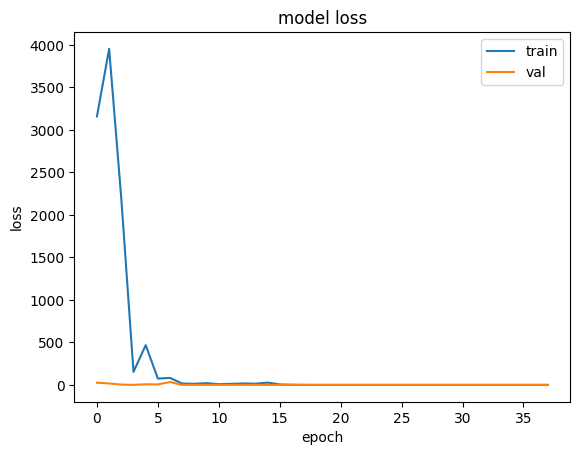

Training loss on the final epoch was: 0.3881


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print(f"Training loss on the final epoch was: {history.history['loss'][-1]:0.4f}")
plt.show()

## ***Save and load the neural model***
Additionally, this section covers saving or loading the trained neural network model from the directory where it is stored in the GitHub repository.


In [ ]:
pip install pyyaml h5py  # package required to save NN model in HDF5 format

In [ ]:
### ***NOT REQUIRED***
# ## Saving the trained neural model
# ## directory to save
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
# model.save('Fit_GEV_NN.h5')

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


***Note:***

---
Once you call our trained neural model using the following code, specify the directory where you have stored our trained neural model from the GitHub repository.

In [ ]:
## Load the saved 'trained NN"
## with keras.utils.custom_object_scope({'CustomModel': CustomModel}):
model = keras.models.load_model('/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2/my_model-VSS-based-on-Andrew-suggestion-shape-1.h5')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputlayer (InputLayer)     [(None, 11)]              0         
                                                                 
 layer1 (Dense)              (None, 512)               6144      
                                                                 
 layer2 (Dense)              (None, 512)               262656    
                                                                 
 layer3 (Dense)              (None, 512)               262656    
                                                                 
 layer4 (Dense)              (None, 128)               65664     
                                                                 
 layer5 (Dense)              (None, 128)               16512     
                                                                 
 outputlayer (Dense)         (None, 3)                 387   

### ***Evaluating model at the testing set***

***Note:***

---

To test the trained model, we define a regular grid of size 20 $\times$ 20 on $(\sigma, c)$. We evaluate the model on the test set for various parameter configurations on the regular grid, considering sample sizes of 30, 72, 173, 416, and 1000, with 100 repitition.

In [ ]:
## Generating the parameter configuration for evaluation of the trained NN
## Define 20X20 regular grid across the scale and shape parameter (c) for fixed location parameter set 0
test_grid_size = 20
shape_vals = np.linspace(-1, 0.4, test_grid_size) # changed from -1 to -0.8
scale_vals = 10**np.linspace(np.log10(0.1), np.log10(40), test_grid_size)

from itertools import product
# loc value = 0
# Get all combinations using itertools.product()
grid_scale_shape = np.array(list(product(scale_vals, shape_vals)))
print(grid_scale_shape.shape)

# Perhaps the test parameters to evaluate the NN are:
loc_test = np.repeat(0, len(grid_scale_shape[:,1]))
scale_test= grid_scale_shape[:,0]
shape_test= grid_scale_shape[:,1]

print('loc_test', loc_test.shape)
print('scale_test', scale_test.shape)

(400, 2)
loc_test (400,)
scale_test (400,)


In [ ]:
## *** NOT REQUIRED ****
# ## -- Save the parameter configuration for the test set --
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS
# np.savetxt("test_parameter_configuration.csv",  grid_scale_shape , delimiter=",")

### ***Function defined to generate a test sample for a specific sample size with repetition***

In [ ]:
## Function to compute the Count matrix for the standardized data along with the original sample
def repeated_Z_quantiles_plus_sample(seed, shape, loc, scale, p_vec, N, M):
    """
    Function to return 'Quantile matrix' for different simulated sample over same parameter
    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape, loc, scale_vec = simulated shape, location, scale parameter value
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!

    * p_vec = quantile set
    * N = GEV sample generated for each parameter combination
    * M = no of repeatation in general
    """
    ## setting the seed for sample generation
    random.seed(seed)

    ## -- initializing the matrices & vectors --
    percentile_Matrix = np.empty((M,len(p_vec)))# store the counts
    storeSample = np.empty((M, 1000)) # store original sample
    storeStdSample = np.empty((M, 1000)) # store original sample

    storeIqr = [] # store sample IQR
    storeMean = [] # store sample MEAN
    storeMedian = [] # store sample MEDIAN

    ## -- extracting counts --
    for i in range(M):

        ## sample generation
        X_sample = gev.rvs(c=shape,
                           loc=loc,
                           scale=scale,
                           size=N)

        ## computing sample Median and IQR
        Median_sample = np.median(X_sample)
        Iqr_sample = scipy.stats.iqr(X_sample)

        storeMedian.append(Median_sample)
        storeIqr.append(Iqr_sample)

        ## standardization of the data
        Z_sample = (X_sample-Median_sample)/Iqr_sample
        percentile_Matrix[i,:] = np.percentile(Z_sample, p_vec*np.array(100))

        ## store std sample
        if len(X_sample)==1000:
            ## storing the sample
            storeSample[i, :] = X_sample # dimension n*1000
            storeStdSample[i, :] = Z_sample # dimension n*1000
        else:
            ## we are working with varying sample size
            ## some elements in the matrix will have NaN values
            fill_space_NaN = np.empty((1000-len(X_sample)))
            fill_space_NaN[:] = np.NaN
            storeSample[i,:] = np.concatenate((X_sample, fill_space_NaN))
            storeStdSample[i, :] = np.concatenate((Z_sample, fill_space_NaN))

    return storeSample, storeStdSample, percentile_Matrix, np.array(storeMedian), np.array(storeIqr)

### ***Evaluating on the test set for GEV sample size of 30***

In [ ]:
batch_size= 128

M = 100 # M stand for the number of repitition

pred_loc_30_ = np.empty((len(shape_test), M))
pred_shape_30_ = np.empty((len(shape_test), M))
pred_scale_30_ = np.empty((len(shape_test), M))

sample_30_over_rep = np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  print('Parameter Configuration', i)

  storeSampleTest30, storeStdSampleTest30, percentileMatTest30, sampleMediansTest30, sampleIQRsTest30= repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                        shape=shape_test[i],
                                                                                                                                        loc=loc_test[i],
                                                                                                                                        scale=scale_test[i],
                                                                                                                                        p_vec=p_set,
                                                                                                                                        N=30,
                                                                                                                                        M=M)

  ## Calculate the sample minimum and maximum
  sample_min_test30 = np.nanmin(storeSampleTest30, axis=1)
  sample_max_test30 = np.nanmax(storeSampleTest30, axis=1)

  ## Calculate the std sample minimum and maximum
  std_sample_min_test30 = np.nanmin(storeStdSampleTest30, axis=1)
  std_sample_max_test30 = np.nanmax(storeStdSampleTest30, axis=1)

  ## Scaled parameter values
  sc_loc_test30 = (loc_test[i]/sampleIQRsTest30) - (sampleMediansTest30/sampleIQRsTest30)
  sc_scale_test30 = scale_test[i]/sampleIQRsTest30

  ## Checking for frechet or weibull distribution:
  is_weibull_test30 = shape_test[i] > mch_epsilon
  is_frechet_test30 = shape_test[i] < -mch_epsilon

  ## Further reparameterization from sc_sigma to delta:
  delta_frechet_test30 = np.log(sc_scale_test30 - shape_test[i]*(std_sample_min_test30  - sc_loc_test30))
  delta_weibull_test30 = np.log(sc_scale_test30 - shape_test[i]*(std_sample_max_test30  - sc_loc_test30))
  delta_test30 = np.where(is_weibull_test30, delta_weibull_test30, delta_frechet_test30)

  ## Fixing the dimension of the shape parameter across the repitition
  shape_test_30 = np.repeat(shape_test[i], len(sc_scale_test30))

  ## -- Test Dataset --
  Z_test30 = percentileMatTest30
  sample_test30 = storeSampleTest30
  sample_30_over_rep[i,:,:] = sample_test30

  ## stacking the location, scale and shape parameters: Testing parameter
  Y_test30 = np.transpose((sc_loc_test30,
                           delta_test30,
                           shape_test_30))

  ## tensors_test30= Z_test30, Y_test30, sample_test30
  tensors_test30 = Z_test30, Y_test30
  test_dataset30 = tf.data.Dataset.from_tensor_slices(tensors_test30).batch(batch_size)

  ## Model Evaluation
  model.evaluate(test_dataset30, batch_size=batch_size)

  ## -- Prediction over the test set --
  pred_vals30 = model.predict(Z_test30) # predicting the sc_loc, delta and shape parameters

  ## -- Location, Scale, and Shape predictions
  sc_loc_pred_vals30 = pred_vals30[:,0]
  delta_pred_vals30 = pred_vals30[:,1]
  shape_pred_vals30 = pred_vals30[:,2]

  ## Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred30 = shape_pred_vals30  > mch_epsilon
  is_frechet_pred30 = shape_pred_vals30  < -mch_epsilon

  ## for frechet
  sc_scale_frechet_pred_vals = (shape_pred_vals30*(std_sample_min_test30 - sc_loc_pred_vals30)) + np.exp(delta_pred_vals30)
  ## for weibull
  sc_scale_weibull_pred_vals = (shape_pred_vals30*(std_sample_max_test30 - sc_loc_pred_vals30)) + np.exp(delta_pred_vals30)

  ## Estimate of the transformed scale parameter
  sc_scale_pred_vals30 = np.where(is_weibull_pred30, sc_scale_weibull_pred_vals, sc_scale_frechet_pred_vals)

  ## -- Back-transformed Location, Scale parameter:
  ## Transforming back to original form of location and scale parameter values
  loc_pred_vals30 = np.array(sc_loc_pred_vals30)*np.array(sampleIQRsTest30) + sampleMediansTest30
  scale_pred_vals30 = np.array(sc_scale_pred_vals30)*np.array(sampleIQRsTest30)

  pred_loc_30_[i,:] =  loc_pred_vals30
  pred_scale_30_[i,:] =  scale_pred_vals30
  pred_shape_30_[i,:] = shape_pred_vals30

tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

Parameter Configuration 0
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 1


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 8ms/step
Parameter Configuration 2
4/4 [==============================] - 0s 9ms/step
Parameter Configuration 3
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 4
4/4 [==============================] - 0s 9ms/step
Parameter Configuration 5
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 6
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 7
4/4 [==============================] - 0s 9ms/step
Parameter Configuration 8
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 9
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 10
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 11
4/4 [==============================] - 0s 8ms/step
Parameter Configuration 12
4/4 [==============================] - 0s 28ms/step
Parameter Configuration 13
4/4 [==============================] - 0s 36ms/step
Parameter Configura

<ipython-input-45-b7f87303e74f>:7: RuntimeWarning: invalid value encountered in log
  np.log(pred_scale_30_),


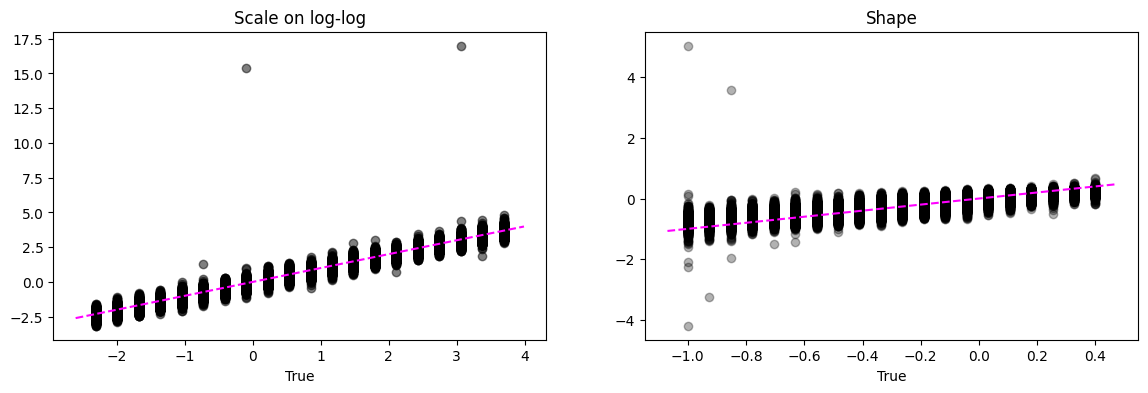

In [ ]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_30_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_30_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()
#f.savefig('Using3DiffAF-Mean-IQR.jpg', bbox_inches='tight',dpi=1200)

In [ ]:
### *** NOT REQUIRED ***
# ## Storing results:

# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
# np.savetxt("pred_scale_30_NN.csv",  pred_scale_30_, delimiter=",")
# np.savetxt("pred_shape_30_NN.csv",  pred_shape_30_, delimiter=",")

# ## Save the array to a binary file
# np.save('Sample_test_30_.npy', sample_30_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


### ***Evaluating on the test set for GEV sample size of 72***

In [ ]:
M = 100 # M stand for the number of repitition

pred_loc_72_= np.empty((len(shape_test), M))
pred_shape_72_= np.empty((len(shape_test), M))
pred_scale_72_= np.empty((len(shape_test), M))
sample_72_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest72, storeStdSampleTest72, percentileMatTest72, sampleMediansTest72, sampleIQRsTest72 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                         shape=shape_test[i],
                                                                                                                                         loc=loc_test[i],
                                                                                                                                         scale=scale_test[i],
                                                                                                                                         p_vec=p_set,
                                                                                                                                         N=72,
                                                                                                                                         M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test72 = np.nanmin(storeStdSampleTest72, axis=1)
  std_sample_max_test72 = np.nanmax(storeStdSampleTest72, axis=1)

  # Calculate the sample minimum and maximum
  sample_min_test72 = np.nanmin(storeSampleTest72, axis=1)
  sample_max_test72 = np.nanmax(storeSampleTest72, axis=1)

  # Transformed parameter values
  sc_loc_test72 = (loc_test[i]/sampleIQRsTest72) - (sampleMediansTest72/sampleIQRsTest72)
  sc_scale_test72 = scale_test[i]/sampleIQRsTest72

  # Checking for frechet or weibull distribution:
  is_weibull_test72 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test72 = np.log(sc_scale_test72 - shape_test[i]*(std_sample_min_test72  - sc_loc_test72))
  delta_weibull_test72 = np.log(sc_scale_test72 - shape_test[i]*(std_sample_max_test72  - sc_loc_test72))
  delta_test72 = np.where(is_weibull_test72, delta_weibull_test72, delta_frechet_test72)

  # Fixing the dimension of the shape parameter
  shape_test72 = np.repeat(shape_test[i], len(sc_scale_test72))

  # -- Test Dataset --
  Z_test72 = percentileMatTest72
  sample_test72 = storeSampleTest72
  sample_72_over_rep[i,:,:] = sample_test72

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test72 = np.transpose((sc_loc_test72,
                            delta_test72,
                            shape_test72))


  tensors_test72 = Z_test72, Y_test72
  test_dataset72 = tf.data.Dataset.from_tensor_slices(tensors_test72).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset72, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals72 = model.predict(Z_test72) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals72 = pred_vals72[:,0]
  delta_pred_vals72 = pred_vals72[:,1]
  shape_pred_vals72 = pred_vals72[:,2]

  # Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred72 = shape_pred_vals72  > mch_epsilon
  is_frechet_pred72 = shape_pred_vals72  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals72 = (shape_pred_vals72*(std_sample_min_test72 - sc_loc_pred_vals72)) + np.exp(delta_pred_vals72)
  # for weibull
  sc_scale_weibull_pred_vals72 = (shape_pred_vals72*(std_sample_max_test72 - sc_loc_pred_vals72)) + np.exp(delta_pred_vals72)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals72 = np.where(is_weibull_pred72, sc_scale_weibull_pred_vals72, sc_scale_frechet_pred_vals72)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals72 = np.array(sc_loc_pred_vals72)*np.array(sampleIQRsTest72) + sampleMediansTest72
  scale_pred_vals72 = np.array(sc_scale_pred_vals72)*np.array(sampleIQRsTest72)

  pred_loc_72_[i,:] =  loc_pred_vals72
  pred_scale_72_[i,:] =  scale_pred_vals72
  pred_shape_72_[i,:] = shape_pred_vals72
  tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 12ms/step
125
4/4 [==============================] - 0s 14ms/step
250
4/4 [==============================] - 0s 9ms/step
375
4/4 [==============================] - 0s 10ms/step
--- 174.5231409072876 seconds ---


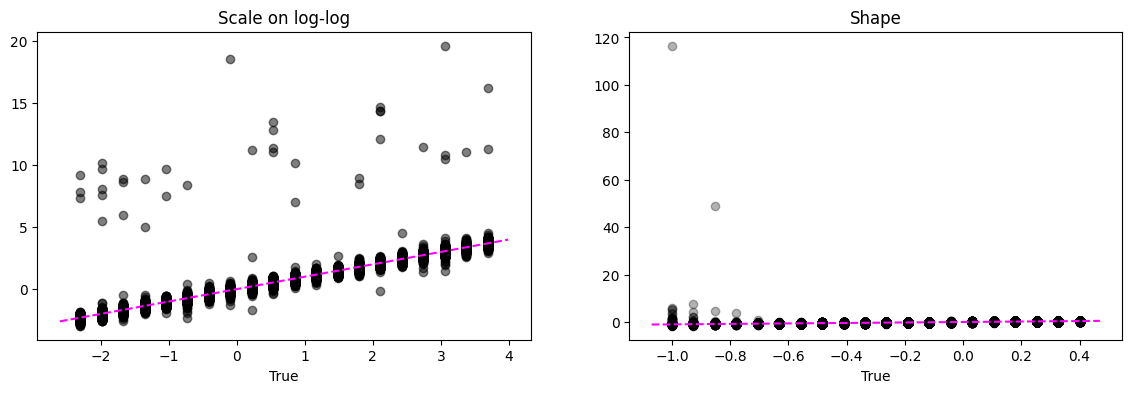

In [ ]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_72_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_72_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [ ]:
# ## Save test sample with repitition along with the results:

# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
# np.savetxt("pred_scale_72_NN.csv",  pred_scale_72_, delimiter=",")
# np.savetxt("pred_shape_72_NN.csv",  pred_shape_72_, delimiter=",")

# ### Save the array to a binary file
# np.save('Sample_test_72_.npy', sample_72_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


In [ ]:
### NOT REQUIRED
### load rb file
# data_72 = np.load('Sample_test_72_.npy')
# np.shape(data_72)
# # Reshape the 3D array to a 2D matrix
# sample_test_72 = data_72.reshape(np.shape(data_72)[0], -1)
# print('2D', sample_test_72.shape)
# np.savetxt("sample_test_72_.csv", sample_test_72, delimiter=",")
#############

### ***Evaluating on the test set for GEV sample size of 173***

In [ ]:
M = 100 # M stand for the number of repitition

pred_loc_173_= np.empty((len(shape_test), M))
pred_shape_173_= np.empty((len(shape_test), M))
pred_scale_173_= np.empty((len(shape_test), M))

sample_173_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest173, storeStdSampleTest173, percentileMatTest173, sampleMediansTest173, sampleIQRsTest173 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                              shape=shape_test[i],
                                                                                                                                              loc=loc_test[i],
                                                                                                                                              scale=scale_test[i],
                                                                                                                                              p_vec=p_set,
                                                                                                                                              N=173,
                                                                                                                                              M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test173 = np.nanmin(storeStdSampleTest173, axis=1)
  std_sample_max_test173 = np.nanmax(storeStdSampleTest173, axis=1)

  # Calculate the sample minimum and maximum
  sample_min_test173 = np.nanmin(storeSampleTest173, axis=1)
  sample_max_test173 = np.nanmax(storeSampleTest173, axis=1)

  # Transformed parameter values
  sc_loc_test173 = (loc_test[i]/sampleIQRsTest173) - (sampleMediansTest173/sampleIQRsTest173)
  sc_scale_test173 = scale_test[i]/sampleIQRsTest173

  # Checking for frechet or weibull distribution:
  is_weibull_test173 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test173 = np.log(sc_scale_test173 - shape_test[i]*(std_sample_min_test173  - sc_loc_test173))
  delta_weibull_test173 = np.log(sc_scale_test173 - shape_test[i]*(std_sample_max_test173  - sc_loc_test173))
  delta_test173 = np.where(is_weibull_test173, delta_weibull_test173, delta_frechet_test173)

  # Fixing the dimension of the shape parameter
  shape_test_173 = np.repeat(shape_test[i], len(sc_scale_test173))

  # -- Test Dataset --
  Z_test173 = percentileMatTest173
  sample_test173 = storeSampleTest173
  sample_173_over_rep[i,:,:] = sample_test173

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test173 = np.transpose((sc_loc_test173,
                            delta_test173,
                            shape_test_173))

  # tensors_test173= Z_test173, Y_test173, sample_test173
  tensors_test173 = Z_test30, Y_test30
  test_dataset173 = tf.data.Dataset.from_tensor_slices(tensors_test173).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset173, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals173= model.predict(Z_test173) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals173 = pred_vals173[:,0]
  delta_pred_vals173 = pred_vals173[:,1]
  shape_pred_vals173 = pred_vals173[:,2]

  # Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred173 = shape_pred_vals173 > mch_epsilon
  is_frechet_pred173 = shape_pred_vals173 < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals173 = (shape_pred_vals173*(std_sample_min_test173 - sc_loc_pred_vals173)) + np.exp(delta_pred_vals173)
  # for weibull
  sc_scale_weibull_pred_vals173 = (shape_pred_vals173*(std_sample_max_test173 - sc_loc_pred_vals173)) + np.exp(delta_pred_vals173)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals173 = np.where(is_weibull_pred173, sc_scale_weibull_pred_vals173, sc_scale_frechet_pred_vals173)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals173 = np.array(sc_loc_pred_vals173)*np.array(sampleIQRsTest173) + sampleMediansTest173
  scale_pred_vals173 = np.array(sc_scale_pred_vals173)*np.array(sampleIQRsTest173)

  pred_loc_173_[i,:] =  loc_pred_vals173
  pred_scale_173_[i,:] =  scale_pred_vals173
  pred_shape_173_[i,:] = shape_pred_vals173

tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 9ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain con

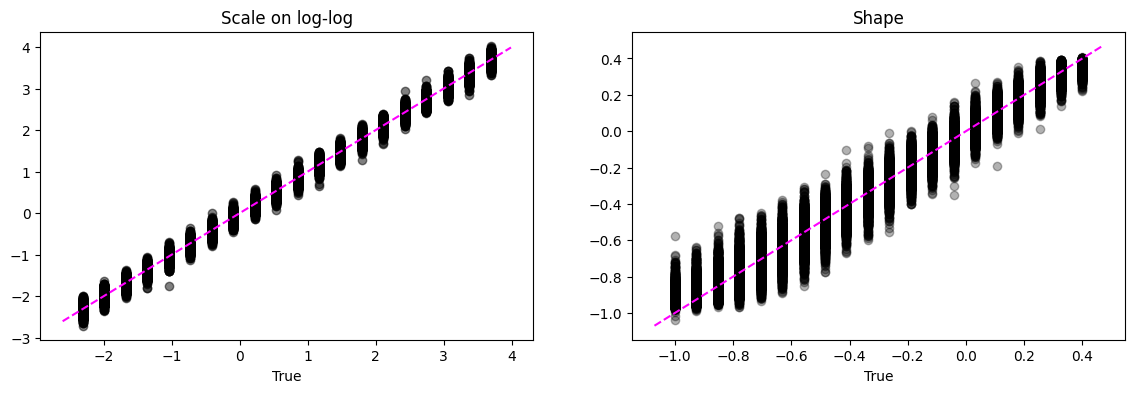

In [ ]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_173_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_173_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [ ]:
### *** NOT REQUIRED ***
# ## Save the test sample with repitition along with the results:
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
# np.savetxt("pred_scale_173_NN_set3.csv",  pred_scale_173_, delimiter=",")
# np.savetxt("pred_shape_173_NN_set3.csv",  pred_shape_173_, delimiter=",")

# ## Save the array to a binary file
# np.save('Sample_test_173_.npy', sample_173_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


### ***Evaluating on the test set for GEV sample size of 416***

In [ ]:
## # -- Computing the Count Matrix --
M = 100 # M stand for the number of repitition

pred_loc_416_= np.empty((len(shape_test), M))
pred_shape_416_= np.empty((len(shape_test), M))
pred_scale_416_= np.empty((len(shape_test), M))
sample_416_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest416, storeStdSampleTest416, percentileMatTest416, sampleMediansTest416, sampleIQRsTest416 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                              shape=shape_test[i],
                                                                                                                                              loc=loc_test[i],
                                                                                                                                              scale=scale_test[i],
                                                                                                                                              p_vec=p_set,
                                                                                                                                              N=416,
                                                                                                                                              M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test416 = np.nanmin(storeStdSampleTest416, axis=1)
  std_sample_max_test416 = np.nanmax(storeStdSampleTest416, axis=1)

  # Calculate the std sample minimum and maximum
  sample_min_test416 = np.nanmin(storeSampleTest416, axis=1)
  sample_max_test416 = np.nanmax(storeSampleTest416, axis=1)

  # Transformed parameter values
  sc_loc_test416 = (loc_test[i]/sampleIQRsTest416) - (sampleMediansTest416/sampleIQRsTest416)
  sc_scale_test416 = scale_test[i]/sampleIQRsTest416

  # Checking for frechet or weibull distribution:
  is_weibull_test416 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test416 = np.log(sc_scale_test416 - shape_test[i]*(std_sample_min_test416  - sc_loc_test416))
  delta_weibull_test416 = np.log(sc_scale_test416 - shape_test[i]*(std_sample_max_test416  - sc_loc_test416))
  delta_test416 = np.where(is_weibull_test416, delta_weibull_test416, delta_frechet_test416)

  # Fixing the dimension of the shape parameter
  shape_test416 = np.repeat(shape_test[i], len(sc_scale_test416))

  # -- Test Dataset --
  Z_test416 = percentileMatTest416
  sample_test416 = storeSampleTest416
  sample_416_over_rep[i,:,:] = sample_test416

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test416 = np.transpose((sc_loc_test416,
                            delta_test416,
                            shape_test416))

  # tensors_test30= Z_test30, Y_test30, sample_test30
  tensors_test416 = Z_test416, Y_test416
  test_dataset416 = tf.data.Dataset.from_tensor_slices(tensors_test416).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset416, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals416 = model.predict(Z_test416) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals416 = pred_vals416[:,0]
  delta_pred_vals416 = pred_vals416[:,1]
  shape_pred_vals416 = pred_vals416[:,2]

  # Converting delta_pred_vals30 to sc_scale_pred_vals30
  is_weibull_pred416 = shape_pred_vals416  > mch_epsilon
  is_frechet_pred416 = shape_pred_vals416  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals416 = (shape_pred_vals416*(std_sample_min_test416 - sc_loc_pred_vals416)) + np.exp(delta_pred_vals416)
  # for weibull
  sc_scale_weibull_pred_vals416 = (shape_pred_vals416*(std_sample_max_test30 - sc_loc_pred_vals416)) + np.exp(delta_pred_vals416)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals416 = np.where(is_weibull_pred416, sc_scale_weibull_pred_vals416, sc_scale_frechet_pred_vals416)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals416 = np.array(sc_loc_pred_vals416)*np.array(sampleIQRsTest416) + sampleMediansTest416
  scale_pred_vals416 = np.array(sc_scale_pred_vals416)*np.array(sampleIQRsTest416)

  pred_loc_416_[i,:] =  loc_pred_vals416
  pred_scale_416_[i,:] =  scale_pred_vals416
  pred_shape_416_[i,:] = shape_pred_vals416
  tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 9ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 11ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain co

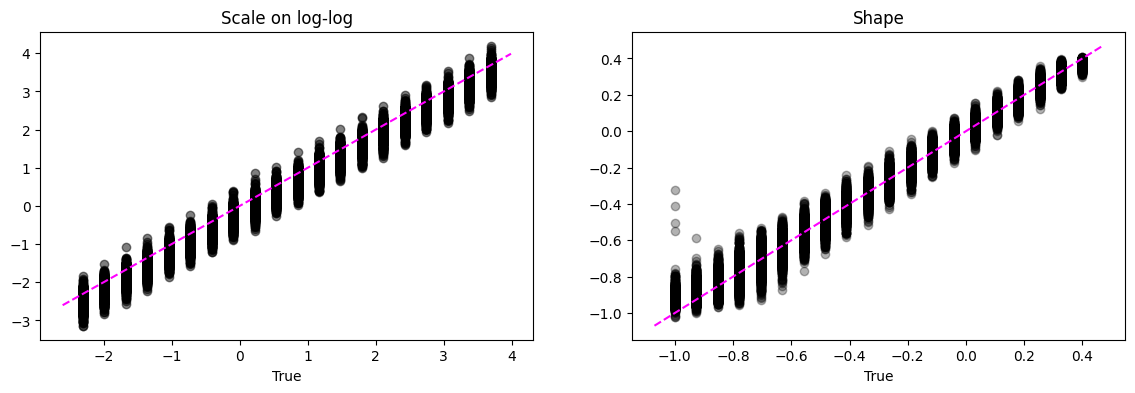

In [ ]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_416_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_416_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [ ]:
# ## Save the test sample with repitition along with the results:
# ## np.savetxt("pred_loc_416_NN_andrew.csv",  pred_loc_416_, delimiter=",")
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
# np.savetxt("pred_scale_416_NN_set3.csv",  pred_scale_416_, delimiter=",")
# np.savetxt("pred_shape_416_NN_set3.csv",  pred_shape_416_, delimiter=",")

# ## Save the array to a binary file
# np.save('Sample_test_416_.npy', sample_416_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


### Test sample for sample size 1000

In [ ]:
M = 100 # M stand for the number of repitition

pred_loc_1000_= np.empty((len(shape_test), M))
pred_shape_1000_= np.empty((len(shape_test), M))
pred_scale_1000_= np.empty((len(shape_test), M))
sample_1000_over_rep= np.empty((len(shape_test), M, 1000))

start_time= time.time()
for i in range(len(shape_test)):
  # -- Bootstrap --
  # idiot numbers; just to check the loop
  if i%125 == 0:
     print(i)

  storeSampleTest1000, storeStdSampleTest1000, percentileMatTest1000, sampleMediansTest1000, sampleIQRsTest1000 = repeated_Z_quantiles_plus_sample(seed=i,
                                                                                                                                                   shape=shape_test[i],
                                                                                                                                                   loc=loc_test[i],
                                                                                                                                                   scale=scale_test[i],
                                                                                                                                                   p_vec=p_set,
                                                                                                                                                   N=1000,
                                                                                                                                                   M=M)

  # Calculate the std sample minimum and maximum
  std_sample_min_test1000 = np.nanmin(storeStdSampleTest1000, axis=1)
  std_sample_max_test1000 = np.nanmax(storeStdSampleTest1000, axis=1)

  # Calculate the std sample minimum and maximum
  sample_min_test1000 = np.nanmin(storeSampleTest1000, axis=1)
  sample_max_test1000 = np.nanmax(storeSampleTest1000, axis=1)

  # Transformed parameter values
  sc_loc_test1000 = (loc_test[i]/sampleIQRsTest1000) - (sampleMediansTest1000/sampleIQRsTest1000)
  sc_scale_test1000 = scale_test[i]/sampleIQRsTest1000

  # Checking for frechet or weibull distribution:
  is_weibull_test1000 = shape_test[i] > mch_epsilon

  # Further transform parameters to delta
  delta_frechet_test1000 = np.log(sc_scale_test1000 - shape_test[i]*(std_sample_min_test1000  - sc_loc_test1000))
  delta_weibull_test1000 = np.log(sc_scale_test1000 - shape_test[i]*(std_sample_max_test1000  - sc_loc_test1000))
  delta_test1000 = np.where(is_weibull_test1000, delta_weibull_test1000, delta_frechet_test1000)

  # Fixing the dimension of the shape parameter
  shape_test1000 = np.repeat(shape_test[i], len(sc_scale_test1000))

  # -- Test Dataset --
  Z_test1000 = percentileMatTest1000
  sample_test1000 = storeSampleTest1000
  sample_1000_over_rep[i,:,:] = sample_test1000

  # stacking the location, scale and shape parameters: Testing parameter
  Y_test1000 = np.transpose((sc_loc_test1000,
                            delta_test1000,
                            shape_test1000))

  # tensors_test30= Z_test30, Y_test30, sample_test30
  tensors_test1000 = Z_test1000, Y_test1000
  test_dataset1000 = tf.data.Dataset.from_tensor_slices(tensors_test1000).batch(batch_size)

  # Model Evaluation
  model.evaluate(test_dataset1000, batch_size=batch_size)

  # -- Prediction over the test set --
  pred_vals1000 = model.predict(Z_test1000) # predicting the sc_loc, delta and shape parameters

  # -- Location, Scale, and Shape predictions
  sc_loc_pred_vals1000 = pred_vals1000[:,0]
  delta_pred_vals1000 = pred_vals1000[:,1]
  shape_pred_vals1000 = pred_vals1000[:,2]

  # Converting delta_pred_vals1000 to sc_scale_pred_vals1000
  is_weibull_pred1000 = shape_pred_vals1000  > mch_epsilon
  is_frechet_pred1000 = shape_pred_vals1000  < -mch_epsilon

  # for frechet
  sc_scale_frechet_pred_vals1000 = (shape_pred_vals1000*(std_sample_min_test1000 - sc_loc_pred_vals1000)) + np.exp(delta_pred_vals1000)
  # for weibull
  sc_scale_weibull_pred_vals1000 = (shape_pred_vals1000*(std_sample_max_test1000 - sc_loc_pred_vals1000)) + np.exp(delta_pred_vals1000)

  # Estimate of the transformed scale parameter
  sc_scale_pred_vals1000 = np.where(is_weibull_pred1000, sc_scale_weibull_pred_vals1000, sc_scale_frechet_pred_vals1000)

  # -- Back-transformed Location, Scale parameter
  # Transforming back to original form of location and scale parameter values
  loc_pred_vals1000 = np.array(sc_loc_pred_vals1000)*np.array(sampleIQRsTest1000) + sampleMediansTest1000
  scale_pred_vals1000 = np.array(sc_scale_pred_vals1000)*np.array(sampleIQRsTest1000)

  pred_loc_1000_[i,:] =  loc_pred_vals1000
  pred_scale_1000_[i,:] =  scale_pred_vals1000
  pred_shape_1000_[i,:] = shape_pred_vals1000
  tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 7ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain constrain (in %) 100.0
4/4 [==============================] - 0s 8ms/step
Overall violation in domain con

In [ ]:
# ## Save the test sample with repitition along with the results:
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3
# np.savetxt("pred_scale_1000_NN_set3.csv",  pred_scale_1000_, delimiter=",")
# np.savetxt("pred_shape_1000_NN_set3.csv",  pred_shape_1000_, delimiter=",")

# ## Save the array to a binary file
# np.save('Sample_test_1000_.npy', sample_1000_over_rep)

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set3


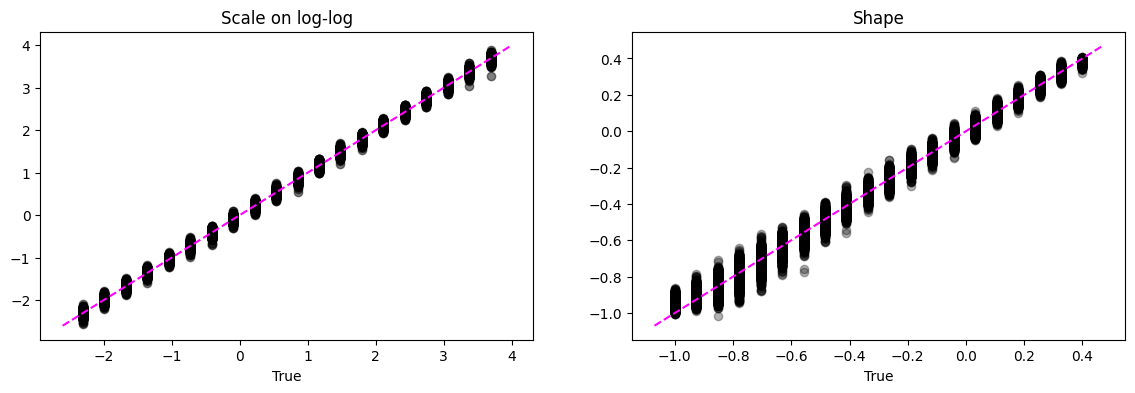

In [ ]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,2,1)

plt.subplot(1,2,1)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_1000_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,2,2)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_1000_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

## ***Bootstrap***


In [ ]:
# Function to compute the Percentile matrix for the standardized data along with the original sample
def repeated_Z_quantiles_plus_sample(seed, shape, loc, scale, p_vec, N, M):
    """
    Function to return 'Quantile matrix' for different simulated sample over same parameter
    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape, loc, scale_vec = simulated shape, location, scale parameter value
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!

    * p_vec = quantile set
    * N = GEV sample generated for each parameter combination
      -> is set to 100 for now.
    * M = no of repeatation in general
    """
    # setting the seed for sample generation
    random.seed(seed)

    # -- initializing the matrices & vectors --
    percentile_Matrix = np.empty((M,len(p_vec)))# store the counts
    storeSample = np.empty((M, N)) # store original sample
    storeStdSample = np.empty((M, N)) # store original sample

    storeIqr = [] # store sample IQR
    storeMedian = [] # store sample MEDIAN

    storeStdMin = []
    storeStdMax = []

    # -- extracting counts --
    for i in range(M):

        # sample generation
        X_sample = gev.rvs(c=shape,
                           loc=loc,
                           scale=scale,
                           size=N)

        # computing sample Median and IQR
        Median_sample = np.median(X_sample)
        Iqr_sample = scipy.stats.iqr(X_sample)


        storeMedian.append(Median_sample)
        storeIqr.append(Iqr_sample)

        # standardization of the data
        Z_sample = (X_sample-Median_sample)/Iqr_sample
        percentile_Matrix[i,:] = np.percentile(Z_sample, p_vec*np.array(100))

        storeSample[i, :] = X_sample # dimension n*1000
        storeStdSample[i, :] = Z_sample

        storeStdMin.append(np.min(Z_sample))
        storeStdMax.append(np.max(Z_sample))

        storeStdSample[i, :] = Z_sample # dimension n*1000
        storeSample[i, :]= X_sample # dimension n*1000
        storeStdSample[i, :]= Z_sample # dimension n*1000

        ## # store std sample
        ## if len(X_sample)==1000:
        ##     # storing the sample
        ##     storeSample[i, :] = X_sample # dimension n*1000
        ##     storeStdSample[i, :] = Z_sample # dimension n*1000
        ## else:
        ##     # we are working with varying sample size
        ##     # some elements in the matrix will have NaN values
        ##     fill_space_NaN = np.empty((1000-len(X_sample)))
        ##     fill_space_NaN[:] = np.NaN
        ##     storeSample[i,:] = np.concatenate((X_sample, fill_space_NaN))
        ##     storeStdSample[i, :] = np.concatenate((Z_sample, fill_space_NaN))

    return storeSample, storeStdSample, percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeStdMin), np.array(storeStdMax)

In [ ]:
# -- Generating sample for Bootstrap Sample to avoid looping -- #
def boot_Z_quantiles(seed, shape, loc, scale, p_vec, N, B):
    """
    Function to return 'Quantile matrix' for different simulated sample over same parameter
    Arguments:
    * seed = set seed to generate a fix set of random sample from GEV distribution
    * shape, loc, scale_vec = simulated shape, location, scale parameter value
      -> REQUIRED to generate GEV
      -> ALSO RESPONSE VARIABLE!

    * p_vec = quantile set
    * N = GEV sample generated for each parameter combination
      -> is set to 100 for now.
    * B = no of bootstrap repitition
    """
    ## setting the seed for sample generation
    random.seed(seed)

    ## -- initializing the matrices & vectors --
    percentile_Matrix = np.empty((B,len(p_vec)))# store the counts
    storeIqr = [] # store sample IQR
    storeMedian = [] # store sample MEDIAN

    storeZmin = [] # std sample minimum
    storeZmax = [] # std sample maximum

    ## -- extracting percentiles --
    for i in range(B):

        # sample generation
        X_sample = gev.rvs(c=shape,
                           loc=loc,
                           scale=scale,
                           size=N)

        ## computing sample Median and IQR
        Median_sample = np.median(X_sample)
        Iqr_sample = scipy.stats.iqr(X_sample)

        storeMedian.append(Median_sample)
        storeIqr.append(Iqr_sample)

        ## standardization of the data
        Z_sample = (X_sample-Median_sample)/Iqr_sample
        storeZmin.append(np.min(Z_sample))
        storeZmax.append(np.max(Z_sample))

        percentile_Matrix[i,:] = np.percentile(Z_sample, p_vec*np.array(100))

    return percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeZmin), np.array(storeZmax)

In [ ]:
## Generating the parameter configuration for evaluation of the network architecture
## we want to set on a 20X20 grid across the scale and shape parameter
test_grid_size= 4
loc_vals = np.linspace(1, 50, test_grid_size) # changed from -1 to -0.8
shape_vals= np.linspace(-0.8, 0.4, test_grid_size) # changed from -1 to -0.8
scale_vals= 10**np.linspace(np.log10(0.1), np.log10(40), test_grid_size)

from itertools import product
## loc value = 0
## Get all combinations using itertools.product()
grid_loc_scale_shape = np.array(list(product(loc_vals, scale_vals, shape_vals)))
print(grid_loc_scale_shape.shape)

## Perhaps the test parameters to evaluate the NN are:
loc_test = grid_loc_scale_shape[:,0]
scale_test= grid_loc_scale_shape[:,1]
shape_test= grid_loc_scale_shape[:,2]

print('loc_test', loc_test)
print('scale_test', scale_test)
print('shape_test', shape_test)

(64, 3)
loc_test [ 1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.         17.33333333 17.33333333
 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333
 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333 17.33333333
 17.33333333 17.33333333 33.66666667 33.66666667 33.66666667 33.66666667
 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667
 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667 33.66666667
 50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.        ]
scale_test [ 0.1         0.1         0.1         0.1         0.7368063   0.7368063
  0.7368063   0.7368063   5.42883523  5.42883523  5.42883523  5.42883523
 40.         40.         40.         40.          0.1         0.1
  0.1        

In [ ]:
boot_test_par = np.transpose(np.vstack((loc_test, scale_test , shape_test)))

In [ ]:
### *** NOT REQUIRED ***
# # np.savetxt("pred_loc_416_NN_andrew.csv",  pred_loc_416_, delimiter=",")
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
# np.savetxt("boot_test_par_over_grid.csv",  boot_test_par, delimiter=",")

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2


In [ ]:
tf.random.set_seed(42)
batch_size = 128

M = 100 # M stand for the number of repitition

pred_loc_ = np.empty((len(shape_test), M))
pred_shape_ = np.empty((len(shape_test), M))
pred_scale_ = np.empty((len(shape_test), M))


sample_over_rep = np.empty((len(shape_test), M, 416)) # here we are working fixed GEV sample of size 416 across the parameter configurations

start_time= time.time()
for i in range(len(shape_test)):
  print('Parameter Configuration', i)
  storeSampleTest416, storeStdSampleTest416, percentileMatTest416, sampleMediansTest416, sampleIQRsTest416, std_sample_min_test416, std_sample_max_test416  = repeated_Z_quantiles_plus_sample(seed=i^5,
                                                                                                                                                                                               shape=shape_test[i],
                                                                                                                                                                                               loc=loc_test[i],
                                                                                                                                                                                               scale=scale_test[i],
                                                                                                                                                                                               p_vec=p_set,
                                                                                                                                                                                               N=416,
                                                                                                                                                                                               M=M) # NOTE: M here stands for the general repition which is 100

  sc_loc_test416 = (loc_test[i]/sampleIQRsTest416) - (sampleMediansTest416/sampleIQRsTest416)
  sc_scale_test416 = scale_test[i]/sampleIQRsTest416

  ## Checking for frechet or weibull distribution:
  is_weibull_test416 = shape_test[i] > mch_epsilon

  ## Further transform parameters to delta
  delta_frechet_test416 = np.log(sc_scale_test416 - shape_test[i]*(std_sample_min_test416  - sc_loc_test416))
  delta_weibull_test416 = np.log(sc_scale_test416 - shape_test[i]*(std_sample_max_test416  - sc_loc_test416))
  delta_test416 = np.where(is_weibull_test416, delta_weibull_test416, delta_frechet_test416)

  ## Fixing the dimension of the shape parameter
  shape_test416 = np.repeat(shape_test[i], len(sc_scale_test416))

  ## -- Test Dataset --
  Z_test416 = percentileMatTest416
  sample_test416 = storeSampleTest416

  ## stacking the location, scale and shape parameters: Testing parameter
  Y_test416 = np.transpose((sc_loc_test416,
                            delta_test416,
                            shape_test416))


  tensors_test416 = Z_test416, Y_test416
  test_dataset416 = tf.data.Dataset.from_tensor_slices(tensors_test416).batch(batch_size)

  ## Model Evaluation
  model.evaluate(test_dataset416, batch_size=batch_size)

  ## -- Prediction over the test set --
  pred_vals416 = model.predict(Z_test416) # predicting the sc_loc, delta and shape parameters

  ## -- Location, Scale, and Shape predictions
  sc_loc_pred_vals416 = pred_vals416[:,0]
  delta_pred_vals416 = pred_vals416[:,1]
  shape_pred_vals416 = pred_vals416[:,2]

  ## Converting delta_pred_vals1000 to sc_scale_pred_vals1000
  is_weibull_pred416 = shape_pred_vals416  > mch_epsilon
  is_frechet_pred416 = shape_pred_vals416  < -mch_epsilon

  ## for frechet
  sc_scale_frechet_pred_vals416 = (shape_pred_vals416*(std_sample_min_test416 - sc_loc_pred_vals416)) + np.exp(delta_pred_vals416)

  ## for weibull
  sc_scale_weibull_pred_vals416 = (shape_pred_vals416*(std_sample_max_test416 - sc_loc_pred_vals416)) + np.exp(delta_pred_vals416)

  ## Estimate of the transformed scale parameter
  sc_scale_pred_vals416 = np.where(is_weibull_pred416, sc_scale_weibull_pred_vals416, sc_scale_frechet_pred_vals416)

  ## -- Location, Scale, and Shape predictions
  sc_loc_pred_vals416 = pred_vals416[:,0]

  ## -- Back-transformed Location, Scale parameter
  ## Transforming back to original form of location and scale parameter values
  loc_pred_vals416 = np.array(sc_loc_pred_vals416)*np.array(sampleIQRsTest416) + sampleMediansTest416
  scale_pred_vals416 = np.array(sc_scale_pred_vals416)*np.array(sampleIQRsTest416)

  pred_loc_[i,:] = loc_pred_vals416
  pred_scale_[i,:] = scale_pred_vals416
  pred_shape_[i,:] = pred_vals416[:,2]

tot_time_sample_sim= (time.time()-start_time)
print("--- %s seconds ---" %tot_time_sample_sim)

Parameter Configuration 0
4/4 [==============================] - 0s 4ms/step
Parameter Configuration 1
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 2
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 3
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 4
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 5
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 6
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 7
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 8
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 9
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 10
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 11
4/4 [==============================] - 0s 3ms/step
Parameter Configuration 12
4/4 [==============================] - 0s 3ms/s

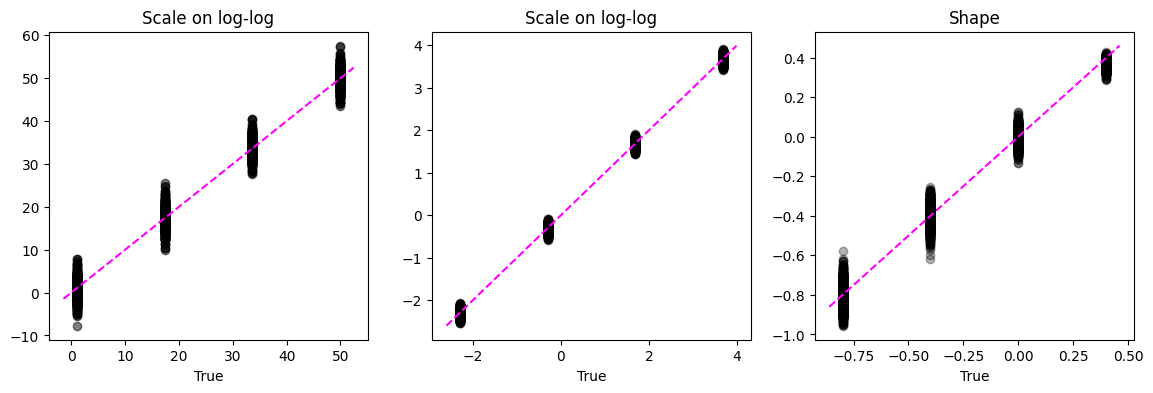

In [ ]:
f= plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
scatter2= plt.scatter(np.repeat(loc_test.reshape((-1,1)), 100, axis=1), #reshaping to get the estimates of the same parameter configuration for 100 repitition
                      pred_loc_,
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,3,2)
scatter2= plt.scatter(np.log(np.repeat(scale_test.reshape((-1,1)), 100, axis=1)),
                      np.log(pred_scale_),
                      color= 'black',
                      alpha=0.5)
plt.xlabel('True')
plt.title('Scale on log-log')
abline(1, 0)

plt.subplot(1,3,3)
plt.scatter(np.repeat(shape_test.reshape((-1,1)), 100, axis=1),
            pred_shape_,
            color= 'black',
            alpha=0.3)
plt.title('Shape')
plt.xlabel('True')
abline(1, 0)

plt.show()

In [ ]:
## Specification of the sample size and number of repetitions:
B = 1000
print('Bootstrap resampling ', B)

M = pred_loc_.shape[1]
print('Sample repetition', M)

N_test = pred_loc_.shape[0]
print('Test Configuration', N_test)

Bootstrap resampling  1000
Sample repetition 100
Test Configuration 64


In [ ]:
 # -- Bootstrapping for Sample Size 416 --
conf_level = 0.95  # confidence level to calculate the coverage
alpha= 0.05

# Initialized matrix and array
boot_est_test = np.empty((N_test, M, 3)) # store the bootstrap estimates: mu, sigma, and  c
boot_sd_test = np.empty((N_test, M, 3))  # store the bootstrap SE of the estimates: mu, sigma, and  c
boot_return_test = np.empty((N_test, M, 5))  # store the return values of bootstrap estimates for 5 different return levels
boot_return_sd_test = np.empty((N_test, M, 5))  # store the return values of bootstrap estimates for 5 different return levels

boot_CI_lower_loc = np.empty((N_test, M))  # store coverage of the location parameter
boot_CI_lower_scale = np.empty((N_test, M))  # store coverage of the scale parameter
boot_CI_lower_shape = np.empty((N_test, M))  # store coverage of the shape parameter

boot_CI_upper_loc = np.empty((N_test, M))  # store coverage of the location parameter
boot_CI_upper_scale = np.empty((N_test, M))  # store coverage of the scale parameter
boot_CI_upper_shape = np.empty((N_test, M))  # store coverage of the shape parameter

# record time
start_time= time.time()
for i in range(N_test):
  print('Parameter Configuration', i)
  for j in range(M):
    print('Repetition', j)
   #  percentile_Matrix, np.array(storeMedian), np.array(storeIqr), np.array(storeZmin), np.array(storeZmax)
    # -- Computing the Percentile Matrix for Bootstrap --
    percentileMatBoot, sampleMediansBoot, sampleIQRsBoot, storeZminBoot, storeZmaxBoot = boot_Z_quantiles(seed=i,
                                                                                                          shape=pred_shape_[i,j],
                                                                                                          loc=pred_loc_[i,j],
                                                                                                          scale=pred_scale_[i,j],
                                                                                                          p_vec=p_set,
                                                                                                          N=416,
                                                                                                          B=B)
    # Bootstrap Estimates
    fitted_vals_boot = model.predict(percentileMatBoot) # dimension (Bx11)

    # scaled estimates of Loc-Scale parameters
    sc_loc_pred_vals_boot = fitted_vals_boot[:,0] # dimension (Bx1)
    delta_pred_vals_boot = fitted_vals_boot[:,1] # dimension (Bx1)
    shape_pred_vals_boot = fitted_vals_boot[:,2]  # dimension (Bx1)

    # Sc- Scale parameter
    # Converting delta_pred_vals1000 to sc_scale_pred_vals1000
    is_weibull_predBoot =  shape_pred_vals_boot  > mch_epsilon

    # for frechet
    sc_scale_frechet_predBoot = (shape_pred_vals_boot*( storeZminBoot - sc_loc_pred_vals_boot)) + np.exp( delta_pred_vals_boot)
    # for weibull
    sc_scale_weibull_predBoot = (shape_pred_vals_boot*( storeZmaxBoot - sc_loc_pred_vals_boot)) + np.exp( delta_pred_vals_boot)

    # Estimate of the transformed scale parameter
    sc_scale_pred_vals_boot = np.where(is_weibull_predBoot, sc_scale_weibull_predBoot,  sc_scale_frechet_predBoot)

    # Back-transformed Loc-Scale parameters
    loc_pred_vals_boot = (sc_loc_pred_vals_boot*sampleIQRsBoot) + sampleMediansBoot # dimension (Bx1)
    scale_pred_vals_boot = sc_scale_pred_vals_boot*sampleIQRsBoot # dimension (Bx1)

    # Storing bootstrap estimates  & standard deviation
    boot_est_test[i,j, ] = [np.mean(loc_pred_vals_boot), np.mean(scale_pred_vals_boot), np.mean(shape_pred_vals_boot)]
    boot_sd_test[i,j, ] = [np.std(loc_pred_vals_boot), np.std(scale_pred_vals_boot), np.std(shape_pred_vals_boot)]

    # Calculate the confidence interval and coverage probability
    lower_percentile = alpha/2
    upper_percentile = 1 - (alpha/2)

    lower_bound_loc = np.quantile(loc_pred_vals_boot, lower_percentile)
    upper_bound_loc = np.quantile(loc_pred_vals_boot, upper_percentile)

    lower_bound_shape = np.quantile(shape_pred_vals_boot, lower_percentile)
    upper_bound_shape = np.quantile(shape_pred_vals_boot, upper_percentile)

    lower_bound_scale = np.quantile(scale_pred_vals_boot, lower_percentile)
    upper_bound_scale = np.quantile(scale_pred_vals_boot, upper_percentile)

    boot_CI_lower_loc[i,j] = lower_bound_loc  # store coverage of the location parameter
    boot_CI_lower_scale[i,j] = lower_bound_scale  # store coverage of the scale parameter
    boot_CI_lower_shape[i,j] = lower_bound_shape  # store coverage of the shape parameter

    boot_CI_upper_loc[i,j] = upper_bound_loc   # store coverage of the location parameter
    boot_CI_upper_scale[i,j] = upper_bound_scale  # store coverage of the scale parameter
    boot_CI_upper_shape[i,j] = upper_bound_shape # store coverage of the shape parameter

print("--- %s seconds ---" % (time.time()-start_time))
tot_time= (time.time()-start_time)

Streaming output truncated to the last 5000 lines.
Repetition 73
32/32 [==============================] - 0s 2ms/step
Repetition 74
32/32 [==============================] - 0s 3ms/step
Repetition 75
32/32 [==============================] - 0s 2ms/step
Repetition 76
32/32 [==============================] - 0s 3ms/step
Repetition 77
32/32 [==============================] - 0s 2ms/step
Repetition 78
32/32 [==============================] - 0s 3ms/step
Repetition 79
32/32 [==============================] - 0s 3ms/step
Repetition 80
32/32 [==============================] - 0s 3ms/step
Repetition 81
32/32 [==============================] - 0s 3ms/step
Repetition 82
32/32 [==============================] - 0s 3ms/step
Repetition 83
32/32 [==============================] - 0s 3ms/step
Repetition 84
32/32 [==============================] - 0s 3ms/step
Repetition 85
32/32 [==============================] - 0s 3ms/step
Repetition 86
32/32 [==============================] - 0s 3ms/step
Repetition 

In [ ]:
## TOTAL TIME:
tot_time/3600

In [ ]:
# Calculating the coverage:
coverage_boot_loc = np.empty((N_test))
coverage_boot_scale = np.empty((N_test))
coverage_boot_shape = np.empty((N_test))
for i in range(N_test):
  print('Parameter Configuration', i)
  for j in range(M):
    print('Repetition', j)

    # Calculate coverage probability
    coverage_boot_loc[i] = np.mean((boot_CI_lower_loc[i,:] < loc_test[i]) & (boot_CI_upper_loc[i,:]> loc_test[i]))
    coverage_boot_scale[i] = np.mean((boot_CI_lower_scale[i,:] < scale_test[i]) & (boot_CI_upper_scale[i,:]> scale_test[i]))
    coverage_boot_shape[i] = np.mean((boot_CI_lower_shape[i,:] < shape_test[i]) & (boot_CI_upper_shape[i,:]> shape_test[i]))

In [ ]:
### *** NOT REQUIRED ***
# # np.savetxt("pred_loc_1000_NN_andrew.csv",  pred_loc_1000_, delimiter=",")
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
# np.savetxt("coverage_boot_loc_on_grid.csv",  coverage_boot_loc, delimiter=",")
# np.savetxt("coverage_boot_scale_on_grid.csv",  coverage_boot_scale, delimiter=",")

# np.savetxt("coverage_boot_shape_on_grid.csv",  coverage_boot_shape, delimiter=",")

/content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2


In [ ]:
# Calculating the bootstap CI width:
boot_CI_width_loc = boot_CI_upper_loc - boot_CI_lower_loc
print("Dimension of the boot_CI_width_loc", np.shape(boot_CI_width_loc))

boot_CI_width_scale = boot_CI_upper_scale - boot_CI_lower_scale
print("Dimension of the boot_CI_width_scale", np.shape(boot_CI_width_scale))

boot_CI_width_shape = boot_CI_upper_shape - boot_CI_lower_shape
print("Dimension of the boot_CI_width_shape", np.shape(boot_CI_width_shape))

In [ ]:
### *** NOT REQUIRED ***
## TO STORE:
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
# np.save("boot_CI_upper_loc.npy",  boot_CI_upper_loc, delimiter=",")
# np.save("boot_CI_lower_loc.npy",  boot_CI_lower_loc, delimiter=",")

# np.save("boot_CI_upper_scale.npy",  boot_CI_upper_scale, delimiter=",")
# np.save("boot_CI_lower_scale.npy",  boot_CI_lower_scale, delimiter=",")

# np.save("boot_CI_upper_shape.npy",  boot_CI_upper_shape, delimiter=",")
# np.save("boot_CI_lower_shape.npy",  boot_CI_lower_shape, delimiter=",")

In [ ]:
### *** NOT REQUIRED ***
# %cd /content/drive/My Drive/Data storage - Paper 1/Latest-Results-Oct17/VSS/Set2
# np.save("boot_CI_width_loc.npy",  boot_CI_width_loc , delimiter=",")
# np.save("boot_CI_width_scale.npy", boot_CI_width_scale, delimiter=",")
# np.save("boot_CI_width_shape.npy",  boot_CI_width_shape, delimiter=",")